In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train["year"] = train["year"].astype(int)
train["month"] = train["month"].astype(int)
test["year"] = test["year"].astype(int)
test["month"] = test["month"].astype(int)

train["year_month"] = train["year"].astype(str) + "_" + train["month"].astype(str)
test["year_month"] = test["year"].astype(str) + "_" + test["month"].astype(str)

In [10]:
test_year_month = test["year_month"].unique().tolist()
train = train[train["year_month"].isin(test_year_month)].reset_index(drop=True)
train

,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,year_month
0,0,24.989139,125.243167,20.0,20110926,2011,9,0.050,NaN,0.000000,...,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10,2011_9
1,2,26.363556,127.735139,20.0,20091014,2009,10,0.025,NaN,0.000000,...,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22,2009_10
2,6,26.490611,128.006361,20.0,20091214,2009,12,0.075,NaN,0.000000,...,0.271522,-0.228263,-0.826202,-2.120513,2.927697,74.737237,5.043686,-4.875091,3928_20,2009_12
3,7,24.291192,124.133547,20.0,NaN,2019,9,0.150,2.0,0.000000,...,0.249907,-0.271250,-0.864149,-3.072371,2.379290,103.066745,4.072083,-39.851563,3624_10,2019_9
4,8,26.605889,127.891639,20.0,20091019,2009,10,0.025,NaN,0.000000,...,0.293361,-0.300967,-0.842449,-2.418277,2.204932,41.848766,2.577677,-1.365655,3927_33,2009_10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10457,14133,26.258083,127.964194,20.0,20091213,2009,12,0.025,NaN,0.000000,...,0.287206,-0.265500,-0.880684,-2.639705,2.529936,42.016223,3.059239,-36.617441,3927_13,2009_12
10458,14134,24.251137,123.882430,20.0,NaN,2019,10,0.000,1.9,0.000000,...,0.283729,-0.136143,-0.814763,-4.907888,2.551365,171.676795,1.937438,0.177412,3623_13,2019_10
10459,14135,24.728611,125.403889,20.0,20110925,2011,9,0.050,NaN,1294.458862,...,0.264897,-0.272008,-0.703634,-1.458936,2.081548,202.985223,-497.151601,-449.711425,3725_01,2011_9
10460,14137,24.797444,125.162417,20.0,20120204.0,2012,2,0.050,NaN,0.000000,...,0.252529,-0.282726,-0.852988,-2.470451,2.327925,54.130453,4.699174,-15.904502,3725_00,2012_2


In [11]:
train_area_mean = train.area.mean()
test_area_mean = test.area.mean()
area_mean = (train_area_mean + test_area_mean) / 2
train["area"] = train["area"].fillna(area_mean)
test["area"] = test["area"].fillna(area_mean)

train["cover_area"] = train.cover * train.area
train["cover_area_log"] = np.log1p(train['cover_area'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


max : 3.688879
min : 0.000000
Skewness: 1.340162
Kurtosis: 0.819180


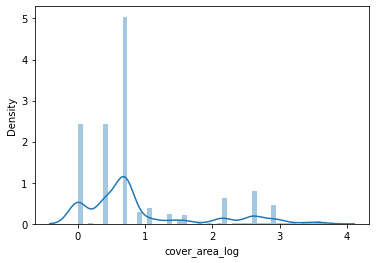

In [12]:
sns.distplot(train["cover_area_log"])

print("max : %f" %train["cover_area_log"].max())
print("min : %f" %train["cover_area_log"].min())
print('Skewness: %f' %train["cover_area_log"].skew())  #歪度
print('Kurtosis: %f' %train["cover_area_log"].kurt())  #尖度

In [13]:
train["adv_flag"] = 0
test["adv_flag"] = 1

df = pd.concat([train,test]).reset_index(drop=True)

In [14]:
train_missing_50 = train_missing[train_missing.percent<0.5].index
test_missing_50 =  test_missing[test_missing.percent<0.5].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features = set(train_missing_50) & set(test_missing_50)
features = set(features) - set(categorical_features) 

In [15]:
len(features)

3159

In [16]:
year_range = list(range(2000,2021))
not_years = [str(col) for col in year_range if col not in test.year.unique().tolist()]
not_features = []
for years in not_years:
  n_f = [col for col in features if years in col]
  not_features += n_f
features = [col for col in features if col not in not_features]

In [17]:
[col for col in features if col in ["year","month","mesh20"]]

['month', 'year']

In [18]:
len(features)

1359

In [19]:
train["year"] = pd.Categorical(train["year"])
train["month"] = pd.Categorical(train["month"])
test["month"] = pd.Categorical(test["month"])
test["year"] = pd.Categorical(test["year"])
display(train[features])

,MAX_AVI_2019,MED_GVMI_2014,MED_TIRS2_2014,MED_Cirededge_2014,MAX_Fe3_2004,MAX_Fe3_2012,MAX_CTVI_2002,MIN_CI_2002,MAX_Alteration_2012,MED_VARIgreen_2004,...,MAX_BWDRVI_2019,MAX_NIR_2014,MIN_Ferric_Oxides_2002,GEMI,MIN_Alteration_2014,IF,MAX_Alteration_2009,MIN_PPR_2019,MAX_GARI_2009,MED_CSI
0,14.297333,0.916101,8.288642,-0.566296,0.641102,0.502376,NaN,NaN,2.172491,2.177338,...,-0.845815,21.790825,NaN,-65.107007,3.872367,2.214614,2.853618,-0.316287,-0.251280,0.981375
1,-37.760155,0.940885,8.048031,-0.670562,0.772976,0.854114,0.391931,-2.257434,3.970313,0.571057,...,-0.960181,13.569036,0.103064,-120.471556,3.996150,2.973305,5.613106,-0.117530,0.114270,1.206447
2,-20.118404,0.960600,8.104766,-0.652665,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.978682,16.506445,NaN,-79.293798,3.877090,2.527918,4.512990,-0.247435,-0.172268,1.109859
3,-15.933259,0.936627,8.050113,-0.680428,0.441804,0.778111,0.575178,-2.249054,3.625031,-3.194033,...,-0.921244,16.300772,0.093660,-206.976268,3.158232,4.602264,NaN,-0.238614,NaN,1.076885
4,-21.974033,0.942061,8.174972,-0.658675,0.459523,NaN,0.363871,-2.210830,NaN,-2.607208,...,-0.932136,13.334732,0.135041,-99.085508,4.063677,2.714684,4.095118,-0.237957,-0.099581,1.028547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10457,-18.751818,0.952834,8.202858,-0.667342,0.443543,0.556965,NaN,NaN,3.968914,-1.757189,...,-0.961582,30.070469,NaN,-74.175197,3.404454,2.594753,5.739475,-0.236825,-0.180111,1.176486
10458,-20.771351,0.937665,8.047388,-0.679554,0.571922,0.778111,0.408531,-2.408044,4.732785,3.908605,...,-0.926777,103.343521,0.077780,-166.647511,2.927678,4.760850,10.900425,-0.163752,-0.057303,1.040759
10459,-1.783073,0.927156,8.230941,-0.234858,0.661191,NaN,0.532034,-3.027789,NaN,1.450872,...,-0.926679,30.632242,0.097316,-4.655067,4.285593,2.373164,5.560237,-0.302726,-0.293100,0.974973
10460,-14.570339,0.921117,8.182147,-0.574350,0.444743,0.438999,NaN,NaN,4.719632,-3.285145,...,-0.966016,18.915007,NaN,NaN,3.698292,NaN,3.474212,-0.274773,-0.214513,0.879030


## Model

In [20]:
#!pip install iterative-stratification

In [21]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [22]:
class CFG:
  ver=26
  model="lightgbm"
  n_folds=4
  trn_fold=[0, 1, 2, 3]
  seed=42
  target_cols1="adv_flag"
  target_cols2="cover"
  boosting_type="gbdt"
  fold_target1="adv_flag"
  fold_target2="cover_area_log"
  fold_target3="cover"

In [23]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df,fold_target, isFlag=False):
  if isFlag:
    Fold = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target], groups=df["mesh20"])):
        df.loc[val_index, 'fold'] = int(n)
  else:
    Fold = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df)):
      df.loc[val_index, 'fold'] = int(n)
  df['fold'] = df['fold'].astype(int)
  display(df.groupby('fold').size())
  return df

In [24]:
def get_score(labels, preds, isFlag=False):
  if isFlag:
    f1score = f1_score(labels, preds)
    pscore = precision_score(labels, preds)
    rscore =recall_score(labels, preds)
    print(f"F1 Score : {f1score}")
    print(f"Precision Score : {pscore}")
    print(f"Recall Score {rscore}")
  else:
    rmse = np.sqrt(mean_squared_error(labels, preds))
    print(f"RMSE {rmse}")

In [25]:
#features = list(features)
features.remove('id')
#features.remove('area')
#features.remove("year")
#features.remove("month")
features.append("mesh20")

In [26]:
params1 = {
        'objective': "binary",
        'metric': 'binary_logloss',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

params2 = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

In [27]:
def get_pred(df, test, fold_target, target_cols, model, isFlag=False):
  if isFlag:
    pred_name = "flag"
    train = get_fold(df, fold_target, isFlag=True)
  else:
    pred_name = ""
    train = get_fold(df, fold_target, isFlag=False)
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))

  ctg_list = ["year","month","mesh20"]

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train['fold'] != fold]
      valid_folds = train[train['fold'] == fold]

      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      #model = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              #categorical_feature = ctg_list,
              verbose = 200,
              early_stopping_rounds=50)
      
      if isFlag:
        pred = model.predict(valid_X)
        predict_proba = model.predict_proba(valid_X)
        valid_folds["Zscore"] = predict_proba[:,1]
        valid_folds[f"{pred_name}_pred"] = pred
      else:
        valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)
        test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(model.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds[f"{pred_name}_pred"], isFlag)

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target_cols], oof_df[f"{pred_name}_pred"], isFlag)
  if isFlag:
    return oof_df
  else:
    return oof_df,  test_preds

In [28]:
# 傾向スコアマッチング関数
def matching(result1, z_col='Zscore', tr_col="adv_flag", match_id='id'):
    '''
    result1: 介入変数、傾向スコア、共変量のデータフレーム
    '''
    # キャリパー設定
    caliper = result1[z_col].std()*0.2

    # 処置群抽出
    Tr = result1[result1[tr_col]>0][[match_id, z_col]].copy().reset_index(drop=True)
    Tr.index = Tr[match_id]
    # 対照群抽出
    Ctl = result1[result1[tr_col]==0][[match_id, z_col]].copy().reset_index(drop=True)
    Ctl.index = Ctl[match_id]
    
    Ctl_vals = np.copy(Ctl[z_col].to_numpy()) # 配列化
    Ctl_ids = np.copy(Ctl.index.to_numpy()) # 配列化
    Tr_vals_dict = Tr[z_col].sort_values(ascending=False).to_dict() # 処置群の傾向スコアで降順にして辞書化

    # マッチングを実施していく
    match_results = [] # 結果を入れる箱
    for i, (cid, tr_val) in tqdm(enumerate(Tr_vals_dict.items())):
        # cid:user_id, tr_val:傾向スコア
        # argminで処置群と最も傾向スコアの差が小さい対照群のインデックス番号取得
        nearId = np.abs(Ctl_vals - tr_val).argmin()
        # 傾向スコアの差がキャリパーより大きかった場合、マッチングしない
        if np.abs(tr_val-Ctl_vals[nearId])>caliper:
            continue
        # 傾向スコアの差がキャリパーより小さかった場合、マッチングした者同士をリストに格納
        match_results.append([cid, Ctl_ids[nearId], tr_val, Ctl_vals[nearId]])
        # 次のマッチングで重複してマッチングしないように対照群のスコアを-9999に置き換える
        np.put(Ctl_vals, [nearId], -9999)

    # リストをdf化
    match_results_df = pd.DataFrame(match_results, columns=['Tr', 'Ctl', 'Tr_zscore', 'Ctl_zscore'])
    match_results_df['diff'] = np.abs(match_results_df['Tr_zscore']-match_results_df['Ctl_zscore'])
    print(match_results_df['diff'].max())
    return match_results_df

In [29]:
#model1 = lgb.LGBMClassifier(**params1)
#flag_oof = get_pred(df, test, CFG.fold_target1, CFG.target_cols1, model1, isFlag=True)

In [30]:
#match_results_df = matching(flag_oof, z_col='Zscore', tr_col='adv_flag', match_id='id')
#display(match_results_df)

In [31]:
#match_id = match_results_df.Ctl.tolist()
#match_train = train[train["id"].isin(match_id)].reset_index(drop=True)
#display(match_train)

fold
0    2616
1    2616
2    2615
3    2615
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.108472
[400]	valid_0's rmse: 0.108154
Early stopping, best iteration is:
[419]	valid_0's rmse: 0.108081


<ipython-input-27-0820502e5d4d>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.10808114782812446
===============  FOLD : 1  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.108914
[400]	valid_0's rmse: 0.108451
Early stopping, best iteration is:
[422]	valid_0's rmse: 0.108376


<ipython-input-27-0820502e5d4d>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.10837358772005479
===============  FOLD : 2  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.108375
[400]	valid_0's rmse: 0.107933
Early stopping, best iteration is:
[388]	valid_0's rmse: 0.107893


<ipython-input-27-0820502e5d4d>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.1078932330962253
===============  FOLD : 3  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.108077
[400]	valid_0's rmse: 0.107393
Early stopping, best iteration is:
[382]	valid_0's rmse: 0.107388


<ipython-input-27-0820502e5d4d>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.10738824848731361


,feature,importance
440,MAX_CI,0.005421
85,MIN_IF,0.004531
671,depth,0.003890
1143,warm_sst,0.003704
1182,VARIgreen,0.003497
405,fetch,0.003414
1222,MAX_BGI,0.003290
887,MAX_VARIgreen_2019,0.003228
1099,MIN_TIRS2_2013,0.003124
595,MIN_IF_2014,0.003083


RMSE 0.1079347060644287


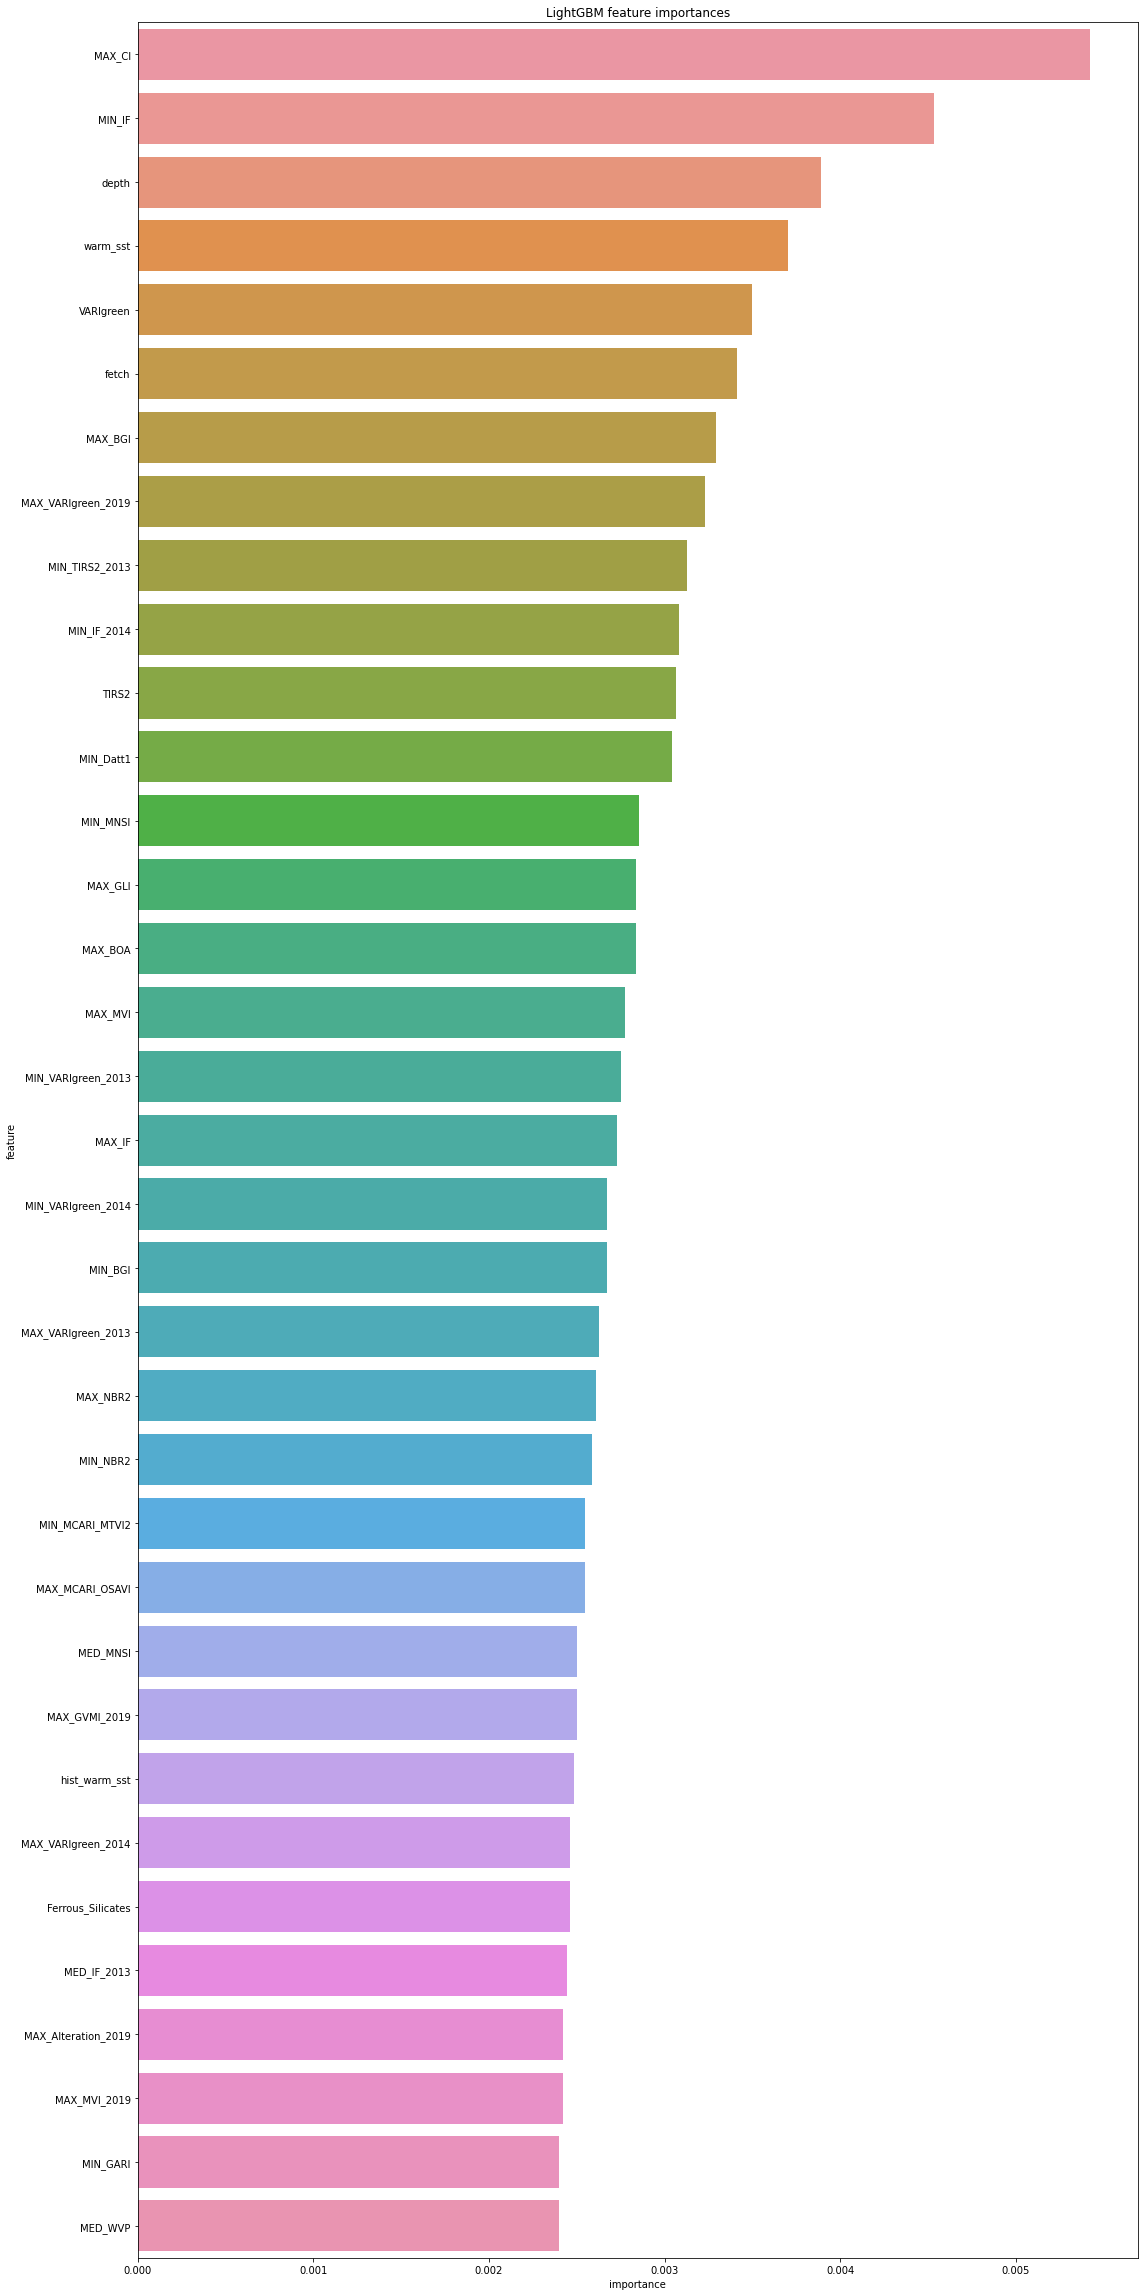

In [32]:
model2 = lgb.LGBMRegressor(**params2)
oof_df, test_pred = get_pred(train, test, CFG.fold_target3, CFG.target_cols2, model2)

In [33]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = _oof["_pred"]
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.10788011054024138


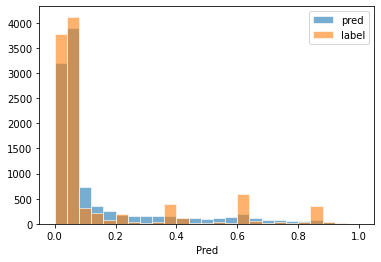

In [34]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [35]:
pred_df = test.copy()
pred_df["pred"] = np.mean(test_pred, axis=1)
pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,year_month,adv_flag,pred
0,0,24.352222,124.202674,20.0,2002.12,2002,12,0.5,0.000000,725.621704,...,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,2002_12,1,0.412943
1,1,24.420028,124.078583,20.0,20100723,2010,7,NaN,0.000000,0.000000,...,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,2010_7,1,0.055159
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004,2,13.8,73.183418,80.595177,...,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,2004_2,1,0.423169
3,3,26.183639,127.319361,20.0,20100805,2010,8,NaN,0.000000,0.000000,...,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,2010_8,1,0.054713
4,4,24.761089,125.269009,20.0,NaN,2019,10,-0.5,0.000000,34.796036,...,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,2019_10,1,0.344835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019,9,0.4,0.000000,20.594961,...,-0.861148,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,2019_9,1,0.075553
4035,4035,24.337028,124.232694,20.0,20101122,2010,11,NaN,0.000000,0.000000,...,-0.833596,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,2010_11,1,0.054762
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004,2,0.1,76.439651,133.127228,...,-0.843974,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,2004_2,1,0.376846
4037,4037,24.068778,123.804194,20.0,20110415,2011,4,NaN,73.660492,0.000000,...,-0.788681,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,2011_4,1,0.052617


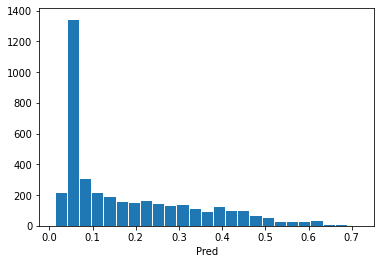

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,year_month,adv_flag,pred
0,0,24.352222,124.202674,20.0,2002.12,2002,12,0.5,0.000000,725.621704,...,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,2002_12,1,0.412943
1,1,24.420028,124.078583,20.0,20100723,2010,7,NaN,0.000000,0.000000,...,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,2010_7,1,0.055159
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004,2,13.8,73.183418,80.595177,...,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,2004_2,1,0.423169
3,3,26.183639,127.319361,20.0,20100805,2010,8,NaN,0.000000,0.000000,...,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,2010_8,1,0.054713
4,4,24.761089,125.269009,20.0,NaN,2019,10,-0.5,0.000000,34.796036,...,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,2019_10,1,0.344835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019,9,0.4,0.000000,20.594961,...,-0.861148,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,2019_9,1,0.075553
4035,4035,24.337028,124.232694,20.0,20101122,2010,11,NaN,0.000000,0.000000,...,-0.833596,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,2010_11,1,0.054762
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004,2,0.1,76.439651,133.127228,...,-0.843974,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,2004_2,1,0.376846
4037,4037,24.068778,123.804194,20.0,20110415,2011,4,NaN,73.660492,0.000000,...,-0.788681,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,2011_4,1,0.052617


In [36]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)

In [41]:
categorical_features

Index(['YMD', 'Landsat_StartTime', 'PRODUCT_ID', 'mesh20', 'year_month'], dtype='object')